# ML: Supervised algorithm - Decision Tree - Top-Selling Shops

## Introduction

We want to predict that there will be a high volume of baby car seat sales. For this, we will rely on the ISLR Carseats dataset that we can download from the statsmodels library.

## 1. Import of libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

As always, let's start by preparing our working environment by loading the necessary libraries. In this case, we want to solve the problem using classification decision trees, so we need to load sklearn's DecisionTreeClassifier library.  Additionally, we are going to load the functions plot_tree, export_graphviz and export_text that we will use later to visualise the resulting tree.

On the other hand, we have the ColumnTrasnformer and OneHotEncoder functions that will be used to apply transformations to the categorical predictor variables. 

## 2. Load datasets

In [2]:
# Generate data for the classification problem
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")

# Dataset description
dataset = carseats.data
print(carseats.__doc__)

.. container::

   ======== ===============
   Carseats R Documentation
   ======== ===============

   .. rubric:: Sales of Child Car Seats
      :name: sales-of-child-car-seats

   .. rubric:: Description
      :name: description

   A simulated data set containing sales of child car seats at 400
   different stores.

   .. rubric:: Usage
      :name: usage

   ::

      Carseats

   .. rubric:: Format
      :name: format

   A data frame with 400 observations on the following 11 variables.

   ``Sales``
      Unit sales (in thousands) at each location

   ``CompPrice``
      Price charged by competitor at each location

   ``Income``
      Community income level (in thousands of dollars)

   ``Advertising``
      Local advertising budget for company at each location (in
      thousands of dollars)

   ``Population``
      Population size in region (in thousands)

   ``Price``
      Price company charges for car seats at each site

   ``ShelveLoc``
      A factor with levels ``Bad``,

We load the data and print information from the dataset. In this case, we find the following 11 predictor variables:

* Sales: units sold (in thousands) in each shop.
* CompPrice: price charged by the competitor in each shop.
* Income: income level of the community (in thousands of dollars).
* Advertising: local advertising budget for the company at each location (in thousands of dollars).
* Population: population size in the region (in thousands).
* ShelveLoc: a categorical variable indicating the quality levels of the shelves in each location: Bad, Good, and Medium.
* Age: average age of the local population.
* Urban: categorical variable indicating whether the shop is located in an urban or rural area. 
* US: categorical variable indicating whether the shop is located in the United States (US) or not. 

## 3. Dataset analysis

In [3]:
dataset.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [4]:
# Let's create the variable 'target' with which we will do the classification.
dataset['target'] = np.where(dataset.Sales > 8, 0, 1)

# We eliminate the variable 'Sales' so as not to duplicate information.
dataset.drop(columns = 'Sales', inplace=True)

In [5]:
dataset.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,target
0,138,73,11,276,120,Bad,42,17,Yes,Yes,0
1,111,48,16,260,83,Good,65,10,Yes,Yes,0
2,113,35,10,269,80,Medium,59,12,Yes,Yes,0
3,117,100,4,466,97,Medium,55,14,Yes,Yes,1
4,141,64,3,340,128,Bad,38,13,Yes,No,1


As we said at the beginning, we want to predict high sales of the product. So we need to create a new variable called target that will help us separate high sales from the rest. In general, we consider high sales if they exceed 8,000 sales. 

In [6]:
dataset.target.value_counts(normalize = True)

1    0.59
0    0.41
Name: target, dtype: float64

We checked the proportion in the target. We have 59% of the data pertaining to high sales while 41% is associated with low sales. 

## 4. Models training

In [26]:
# Separate independent and dependent variables 
X = dataset.drop('target', axis=1)
y = dataset.target

We separate the predictor variables from the independent variable by creating the X and y datasets.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size    = 0.30,
                                                    random_state = 1234,
                                                    shuffle      = True)

We create our train and test dataset that we will use later to evaluate the model. On this occasion, we will leave 30% of the samples for the test.

In [9]:
# One-hot-encoding de las variables categóricas

# We identify numerical and categorical variables
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# We define the one-hot-encoding transformation to the categorical variables
preprocessor = ColumnTransformer([('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],remainder='passthrough')

On this occasion, 3 of the predictor variables are categorical. While it is true that in general decision trees do not need to transform categorical variables into numerical ones, the sklearn package does not allow us to work directly with categorical data. So we will perform a one-hot-encoding transformation.

In [10]:
X_train.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
217,106,44,0,481,111,Medium,70,14,No,No
349,134,27,18,467,96,Medium,49,14,No,Yes
188,116,37,0,426,90,Medium,76,15,Yes,No
267,134,82,7,473,112,Bad,51,12,No,Yes
222,136,119,6,178,145,Medium,35,13,Yes,Yes


In [11]:
# We apply the one-hot-encoding transformation to our dataset. 
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# Name of all columns
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names_out(cat_cols)
labels = np.concatenate([encoded_cat,numeric_cols])

# Conversion to dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels)
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)

In [14]:
X_train_prep.shape

(280, 14)

In [17]:
X_train_prep.sample(5)

,ShelveLoc_Bad,ShelveLoc_Good,ShelveLoc_Medium,Urban_No,Urban_Yes,US_No,US_Yes,CompPrice,Income,Advertising,Population,Price,Age,Education
262,0.0,1.0,0.0,0.0,1.0,1.0,0.0,150.0,96.0,0.0,80.0,154.0,61.0,11.0
115,0.0,1.0,0.0,0.0,1.0,0.0,1.0,141.0,60.0,19.0,319.0,92.0,44.0,11.0
80,0.0,0.0,1.0,0.0,1.0,0.0,1.0,115.0,29.0,26.0,394.0,132.0,33.0,13.0
138,0.0,0.0,1.0,0.0,1.0,0.0,1.0,144.0,63.0,11.0,27.0,117.0,47.0,17.0
75,1.0,0.0,0.0,0.0,1.0,0.0,1.0,103.0,93.0,15.0,188.0,103.0,74.0,16.0


This type of transformation consists of creating a binary variable for each category. For example, in the case of the Urban variable, we will have Urban_No and Urban_Yes associated to when the shop is or is not in an urban or rural area respectively. 

__To go deeper__: the impact that these actions may have on the size of the dataset must be assessed, since if we have variables with a high granularity we may encounter the curse of dimensionality:

* https://www.iartificial.net/la-maldicion-de-la-dimension-en-machine-learning/

### Model 1

In [18]:
# Initialising the model using the default parameters 
dtree_model = DecisionTreeClassifier(random_state = 1234, max_depth = 5)

# Fitting the model to the data
dtree_model.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1234)

We train the model by defining only the following parameters:

* random_state = 1234. This will set the seed to be able to replicate the experiment several times and keep the result.
* max_depth = 5. This will be the only hyperparameter of the model that we will modify. In which we limit the depth of the tree to 5 levels. As you remember from the previous section, this is a fairly common practice to avoid overfitting the model.

__To go deeper__: access the documentation of the DecisionTreeClassifier function to learn more about the rest of the hyperparameters that we could modify:
* https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [19]:
# Predictions

y_pred_train = dtree_model.predict(X_train_prep)
y_pred_test = dtree_model.predict(X_test_prep)

# Model info.
print("Train model prediction:", accuracy_score(y_train, y_pred_train, normalize=True))
print("Test model prediction:", accuracy_score(y_test, y_pred_test, normalize=True))

Precisión del modelo para el train: 0.8785714285714286
Precisión del modelo para el test: 0.75


In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65        44
           1       0.79      0.82      0.81        76

    accuracy                           0.75       120
   macro avg       0.73      0.73      0.73       120
weighted avg       0.75      0.75      0.75       120



We evaluate the prediction of the model with respect to the test and the train. We have an accuracy of 87% for the train data and 75% for the test set. 

Tree depth: 5
Number of terminal nodes: 25


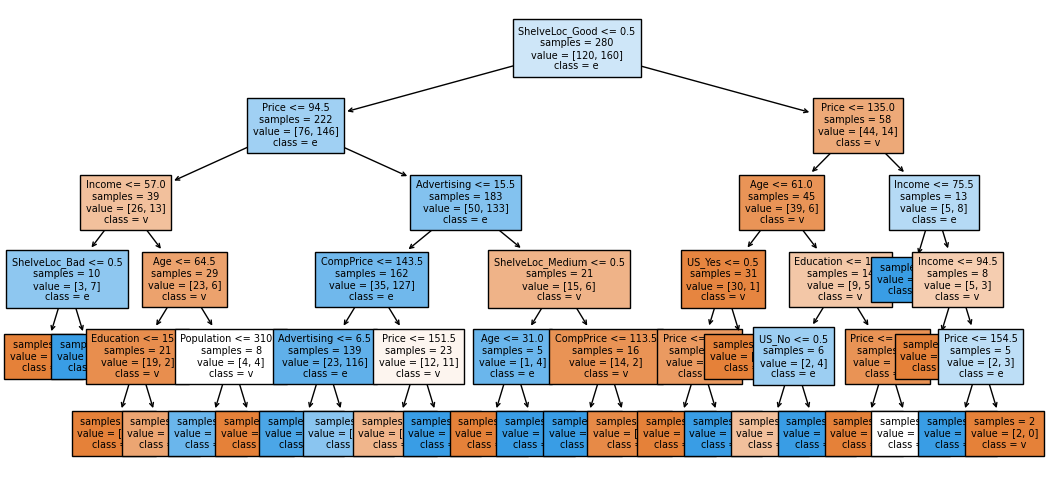

In [33]:
# Decision tree visualisation
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Tree depth: {dtree_model.get_depth()}")
print(f"Number of terminal nodes: {dtree_model.get_n_leaves()}")

plot = plot_tree(
            decision_tree = dtree_model,
            feature_names = labels.tolist(),
            class_names   = 'ventas_altas',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

As previously mentioned, one of the advantages of the decision tree model is the ability to create a visualisation of the model.  This allows us to understand how the algorithm works and to explain the results that are generated.



### Model 2

In [22]:
# Initialising the model using the default parameters 
dtree_model_2 = DecisionTreeClassifier(random_state = 1234, max_depth = 9)

# Fitting the model to the data
dtree_model_2.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=9, random_state=1234)

We are going to train a second model by modifying the tree depth parameter (max_depth). In this case we will limit it to 9. 

In [23]:
# Predict for Test and Train dataset
y_pred_train = dtree_model_2.predict(X_train_prep)
y_pred_test = dtree_model_2.predict(X_test_prep)

# Model information
print("Train model prediction:", accuracy_score(y_train, y_pred_train, normalize=True))
print("Test model prediction:", accuracy_score(y_test, y_pred_test, normalize=True))

Precisión del modelo para el train: 0.9785714285714285
Precisión del modelo para el test: 0.7666666666666667


In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        44
           1       0.83      0.79      0.81        76

    accuracy                           0.77       120
   macro avg       0.75      0.76      0.75       120
weighted avg       0.77      0.77      0.77       120



We performed the prediction for the test and train set and obtained 97% and 76% accuracy respectively.

Profundidad del árbol: 9
Número de nodos terminales: 50


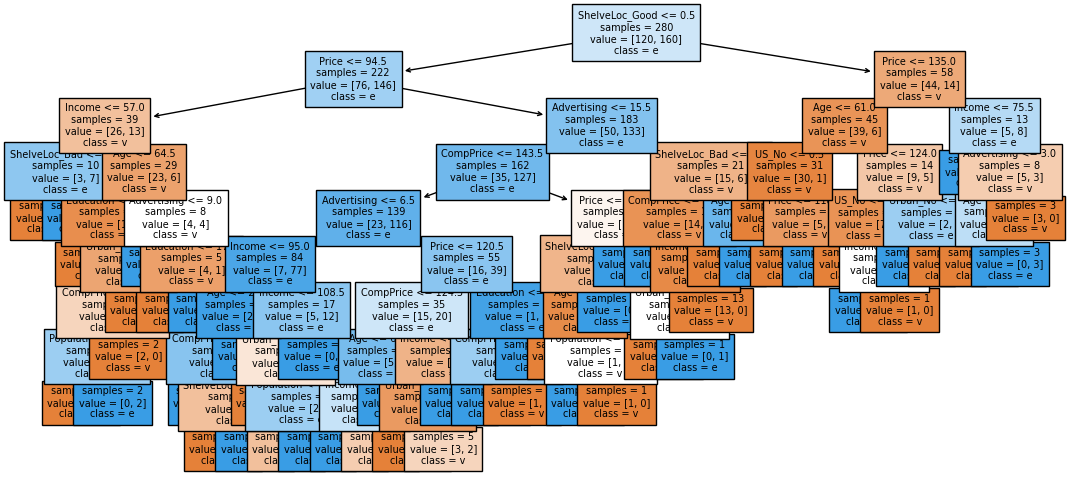

In [25]:
# Decision tree visualisation
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Tree depth: {dtree_model_2.get_depth()}")
print(f"Number of terminal nodes: {dtree_model_2.get_n_leaves()}")

labels = X_train_prep.columns

plot = plot_tree(
            decision_tree = dtree_model_2,
            feature_names = labels.tolist(),
            class_names   = 'ventas_altas',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )

In this case, we obtain a depth tree 9. Quite more complex than the previous model and from which we do not obtain a substantial improvement of the accuracy metric on the test set. Remember that the test set is the one that will allow us to evaluate how the model behaves with new data and that good performance on train data and poor performance on test may be due to overfitting of the model.

In this case, we could say that the first model is a good approximation to solve the problem at hand.